## Nitish Dhinaharan  
## MSCS 634 – Data Mining  
### Lab 3: Clustering Analysis using K-Means and K-Medoids

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix
import random

In [ ]:
# Step 1: Load and Prepare the Dataset

# Load Wine dataset
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = wine.target  # true class labels (for ARI comparison)

# Basic exploration
print("First 5 rows:")
display(X.head())
print("\nClass distribution:")
print(pd.Series(y).value_counts())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nShape of data:", X_scaled.shape)

First 5 rows:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0



Class distribution:
1    71
0    59
2    48
Name: count, dtype: int64

Shape of data: (178, 13)


In [ ]:
# Step 2: Implement K-Means Clustering

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Evaluate performance
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print("=== K-Means Results ===")
print("Silhouette Score:", kmeans_sil)
print("Adjusted Rand Index:", kmeans_ari)

=== K-Means Results ===
Silhouette Score: 0.2848589191898987
Adjusted Rand Index: 0.8974949815093207


In [ ]:
# Step 3: Implement K-Medoids Clustering

# compute a distance matrix from the scaled data.
distance_matrix = calculate_distance_matrix(X_scaled.tolist())

# choose 3 random initial medoids (indices into the dataset)
random.seed(42)
initial_medoids = random.sample(range(len(X_scaled)), 3)
print("Initial medoid indices:", initial_medoids)

# Create and run the K-Medoids algorithm
kmedoids_instance = kmedoids(
    data=distance_matrix,
    initial_index_medoids=initial_medoids,
    data_type='distance_matrix'
)
kmedoids_instance.process()

clusters = kmedoids_instance.get_clusters()          # list of clusters (each is list of point indices)
final_medoids = kmedoids_instance.get_medoids()      # indices of final medoids
print("Final medoid indices:", final_medoids)

# Convert cluster lists to a label array aligned with original samples
kmedoids_labels = np.zeros(len(X_scaled), dtype=int)
for cluster_id, cluster in enumerate(clusters):
    for idx in cluster:
        kmedoids_labels[idx] = cluster_id

# Evaluation
kmedoids_sil = silhouette_score(X_scaled, kmedoids_labels)
kmedoids_ari = adjusted_rand_score(y, kmedoids_labels)

print("\n=== K-Medoids (pyclustering) Results ===")
print("Silhouette Score:", kmedoids_sil)
print("Adjusted Rand Index:", kmedoids_ari)

Initial medoid indices: [163, 28, 6]
Final medoid indices: [174, 106, 35]

=== K-Medoids (pyclustering) Results ===
Silhouette Score: 0.26597740204536796
Adjusted Rand Index: 0.7263406645756675


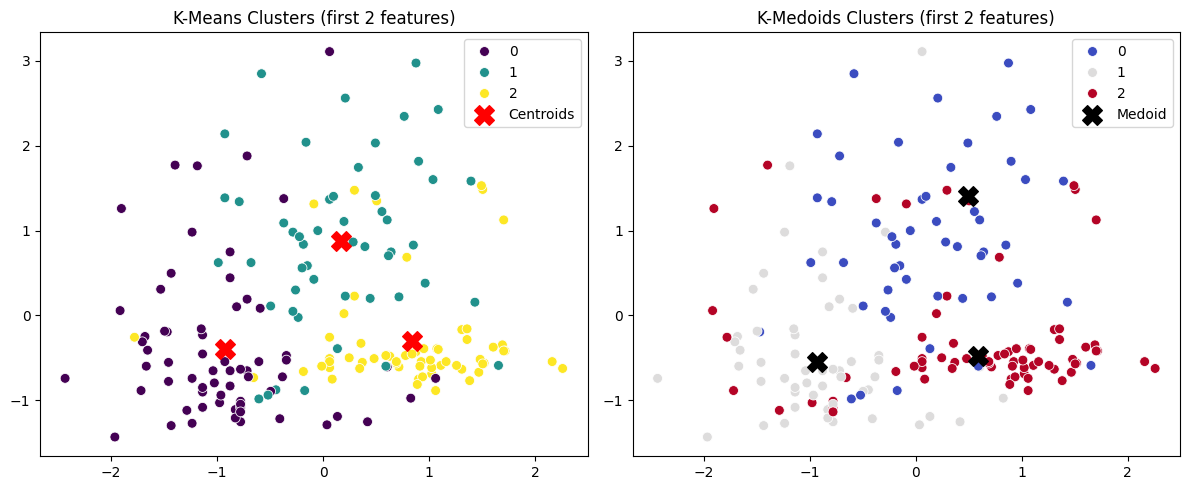

AttributeError: type object 'kmedoids' has no attribute 'cluster_centers_'

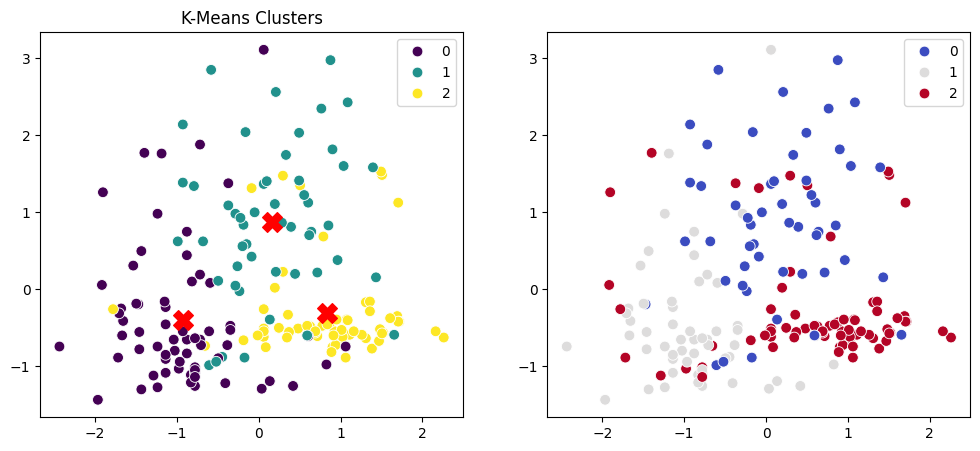

In [ ]:
# Step 4: Visualize and Compare Results

plt.figure(figsize=(12, 5))

# ---- K-Means plot ----
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=kmeans_labels,
    palette='viridis',
    s=50
)
# plot centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c='red',
    marker='X',
    s=200,
    label='Centroids'
)
plt.title("K-Means Clusters (first 2 features)")
plt.legend()

# ---- K-Medoids plot ----
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_scaled[:, 0],
    y=X_scaled[:, 1],
    hue=kmedoids_labels,
    palette='coolwarm',
    s=50
)

# medoids are actual points from the dataset
for m in final_medoids:
    plt.scatter(
        X_scaled[m, 0],
        X_scaled[m, 1],
        c='black',
        marker='X',
        s=200,
        label='Medoid'
    )
# avoid duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("K-Medoids Clusters (first 2 features)")
plt.tight_layout()
plt.show()


# Reduce dimensions for visualization using first two features
plt.figure(figsize=(12,5))

# K-Means plot
plt.subplot(1,2,1)
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=kmeans_labels, palette='viridis', s=60)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', marker='X', s=200)
plt.title("K-Means Clusters")

# K-Medoids plot
plt.subplot(1,2,2)
sns.scatterplot(x=X_scaled[:,0], y=X_scaled[:,1], hue=kmedoids_labels, palette='coolwarm', s=60)
plt.scatter(kmedoids.cluster_centers_[:,0], kmedoids.cluster_centers_[:,1], c='black', marker='X', s=200)
plt.title("K-Medoids Clusters")

plt.tight_layout()
plt.show()